In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv("histo_trafic_avec_dates_5min.csv", sep=None, engine="python")
df["dates_5min"] = pd.to_datetime(df["dates_5min"])
df["trafic_mbps"] = pd.to_numeric(df["trafic_mbps"], errors="coerce")
df = df.sort_values(["secteur", "dates_5min"]).reset_index(drop=True)

os.makedirs("resultats", exist_ok=True)

rows_instant = []   


variance_par_secteur = (
    df.groupby("secteur")["trafic_mbps"]
      .var()
      .sort_values(ascending=False)
)


TOP_N = 5
secteurs_plus_variables = variance_par_secteur.index[:TOP_N].tolist()

tous_les_secteurs = df["secteur"].unique()

# ESTIMATION de TAU et ZETA

def estimate_tau_zeta(mu, var, T=300):
    if mu <= 0 or var <= 0:
        return 0.1, 0.5, 0.1

    ratio_data = var / mu**2

    best_tau, best_zeta, best_err = 0.1, 0.5, 1e9

    tau_list  = np.linspace(0.05, 1.00, 40)
    zeta_list = np.linspace(0.05, 1.00, 40)

    for tau in tau_list:
        for zeta in zeta_list:
            min_ratio = (2*zeta) / (tau * T * (tau + zeta))
            if min_ratio > 0:
                err = abs(ratio_data - min_ratio)
                if err < best_err:
                    best_err, best_tau, best_zeta = err, tau, zeta

    return best_tau, best_zeta, ratio_data


# Calcul de λ ET E(ψ)

def compute_lambda_Epsi(mu, var, tau, zeta, T=300):

    if mu <= 0:
        return 1e-6, 1e-6

    ratio = var / mu**2
    min_ratio = (2*zeta)/(tau*T*(tau+zeta))

    if ratio <= min_ratio:
        ratio = min_ratio + 1e-6
        var = ratio * mu**2

    denom = tau*T*(ratio - min_ratio)
    denom = denom if denom > 0 else 1e-6

    lam = (tau + zeta) / denom
    lam = lam if lam > 0 else 1e-6

    Epsi = (tau + zeta) * mu / (tau * lam * T)
    Epsi = Epsi if Epsi > 0 else 1e-6

    return lam, Epsi

# IPP

def generate_slot_IPP(mu, var, tau, zeta, T=300):
    if mu <= 0:
        return [0.0]*T, [0]*T

    lam, Epsi = compute_lambda_Epsi(mu, var, tau, zeta, T)

    state = np.random.choice([0, 1])
    inst, arrivals = [], []

    for _ in range(T):

        u = np.random.rand()
        if state == 1 and u < tau:
            state = 0
        elif state == 0 and u < zeta:
            state = 1

        if state == 1:
            k = np.random.poisson(lam)
            psi_sum = np.sum(np.random.exponential(Epsi, k)) if k > 0 else 0
        else:
            k, psi_sum = 0, 0

        inst.append(psi_sum)
        arrivals.append(k)

    return inst, arrivals


T_SLOT = 300

for sec in tous_les_secteurs:

    df_sec = df[df["secteur"] == sec].sort_values("dates_5min")

    mu = df_sec["trafic_mbps"].mean()
    var = df_sec["trafic_mbps"].var()

    tau, zeta, ratio = estimate_tau_zeta(mu, var, T=T_SLOT)

    cv2 = var / mu**2 if mu > 0 else 0.1

    for _, row in df_sec.iterrows():

        EPsi = row["trafic_mbps"]
        VarPsi = cv2 * EPsi**2
        start = row["dates_5min"]

        inst, arr = generate_slot_IPP(EPsi, VarPsi, tau, zeta, T=T_SLOT)

        # Ajout au CSV
        for s, psi in enumerate(inst):
            rows_instant.append({
                "secteur": sec,
                "timestamp": start + pd.Timedelta(seconds=s),
                "psi_instant": psi
            })

# Sauvegarde au CSV
df_inst = pd.DataFrame(rows_instant).sort_values(["secteur", "timestamp"])
df_inst.to_csv("instantane.csv", index=False)

print("\n CSV instantané généré pour TOUS les secteurs.")


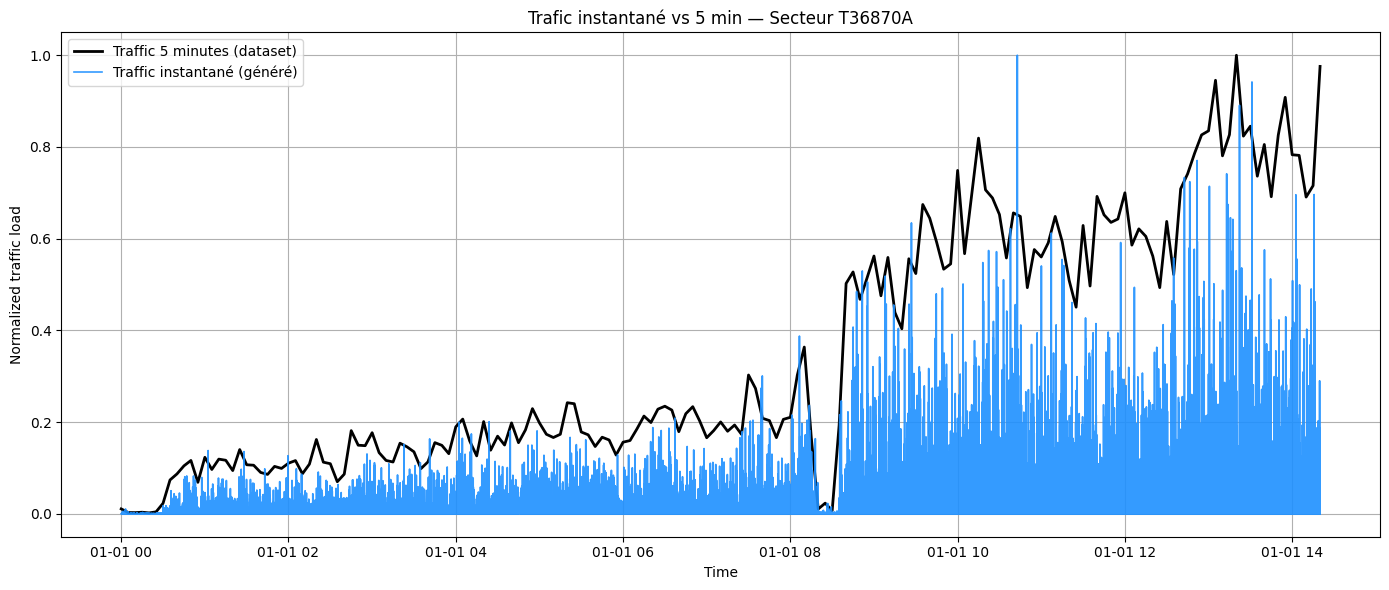

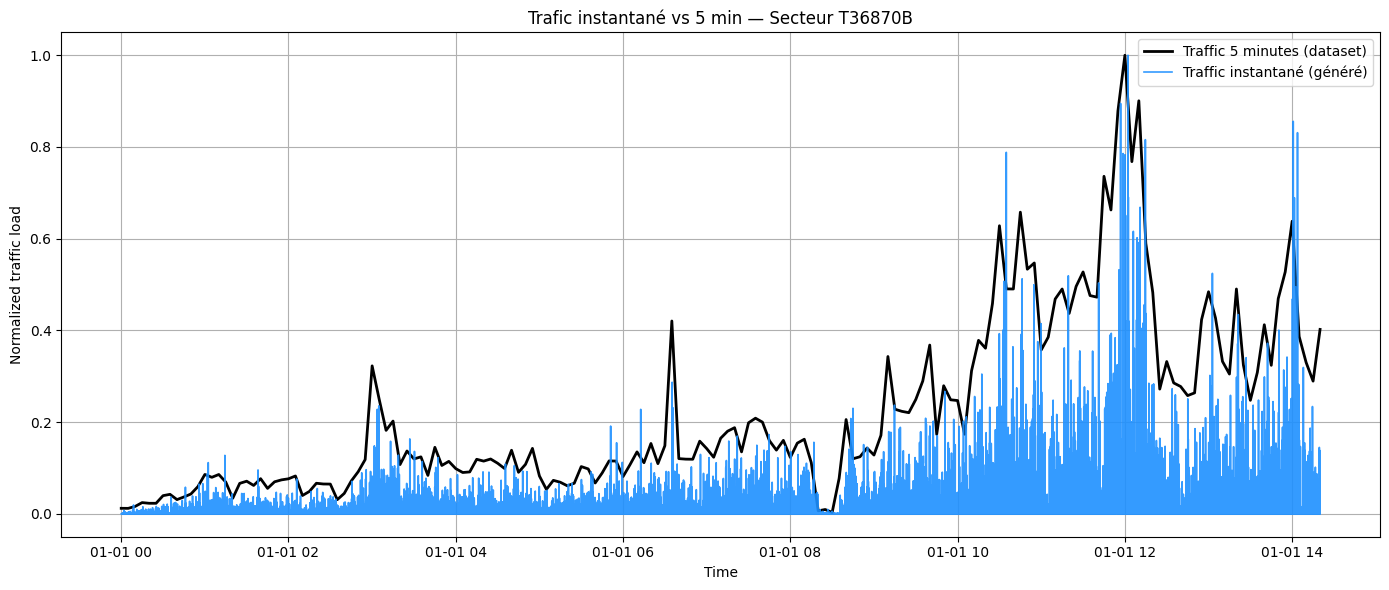

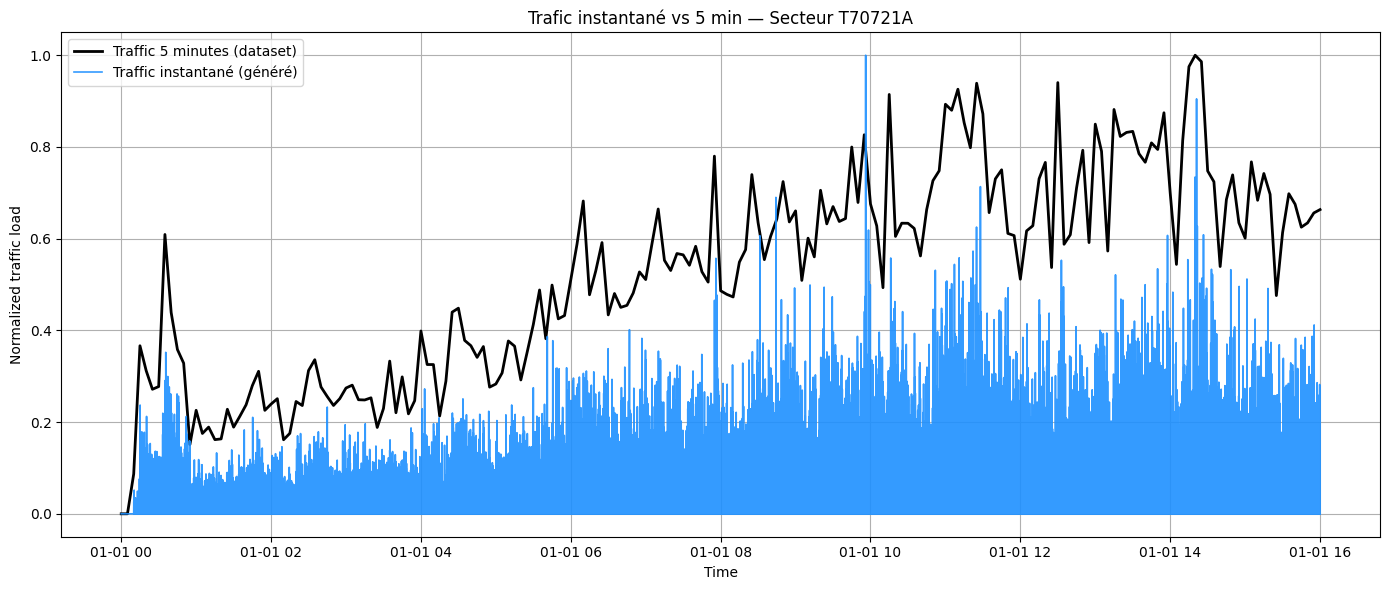

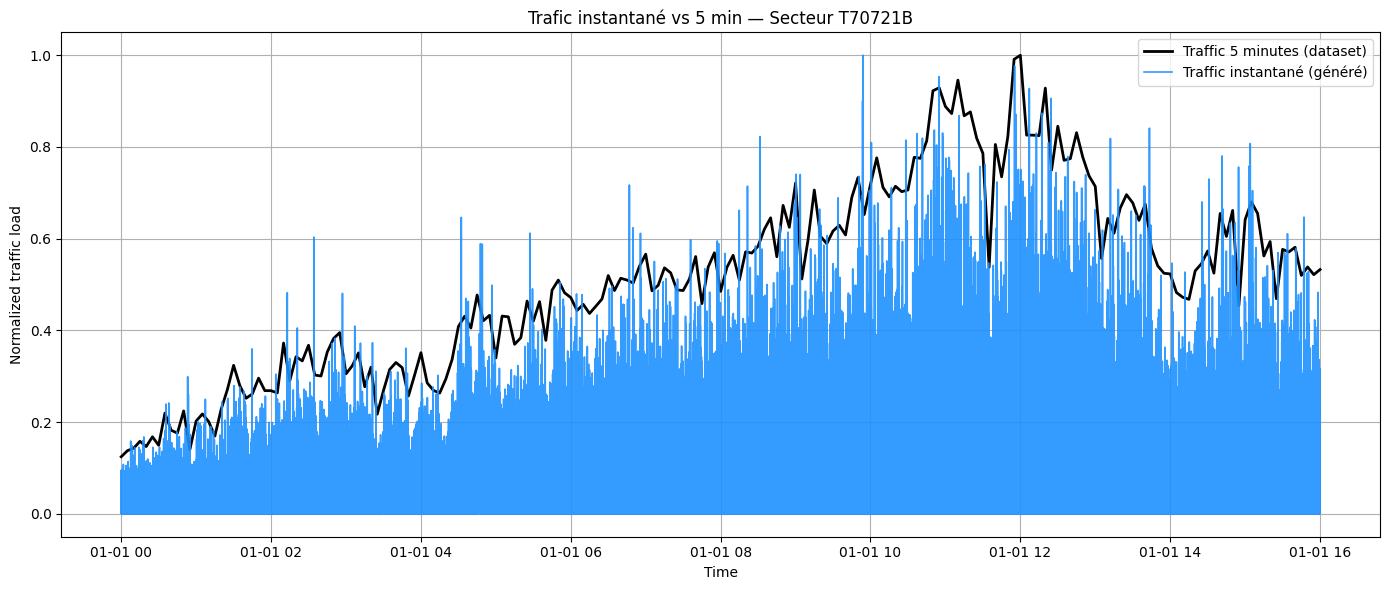

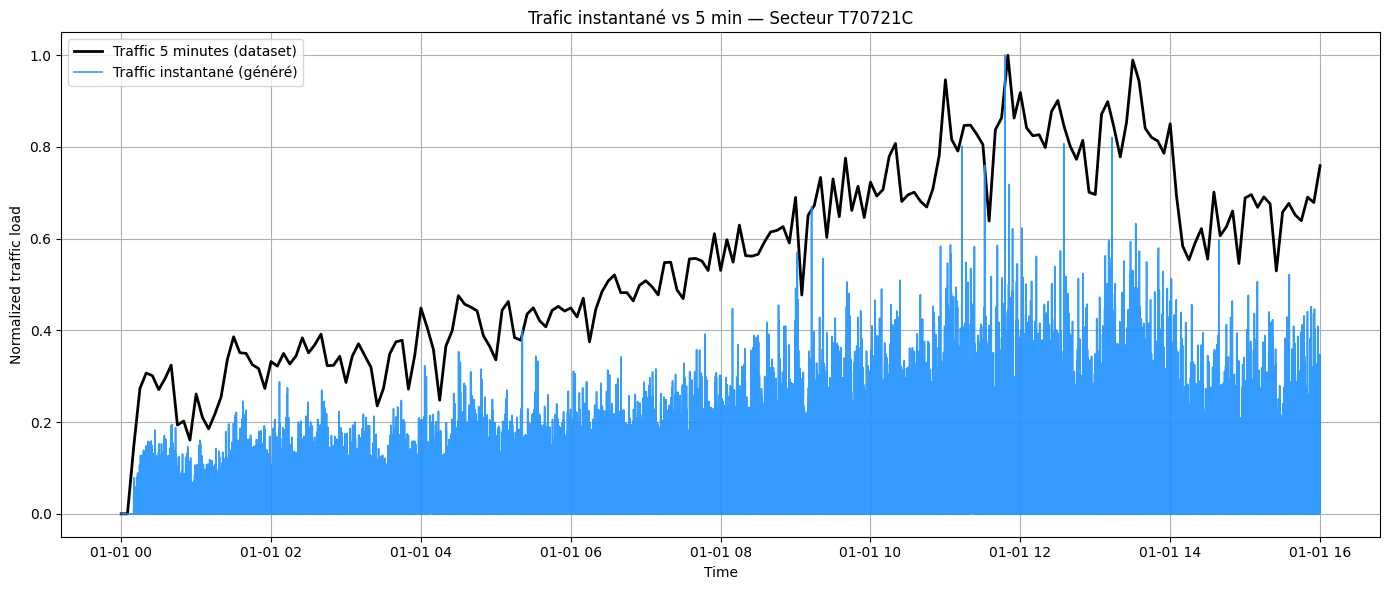

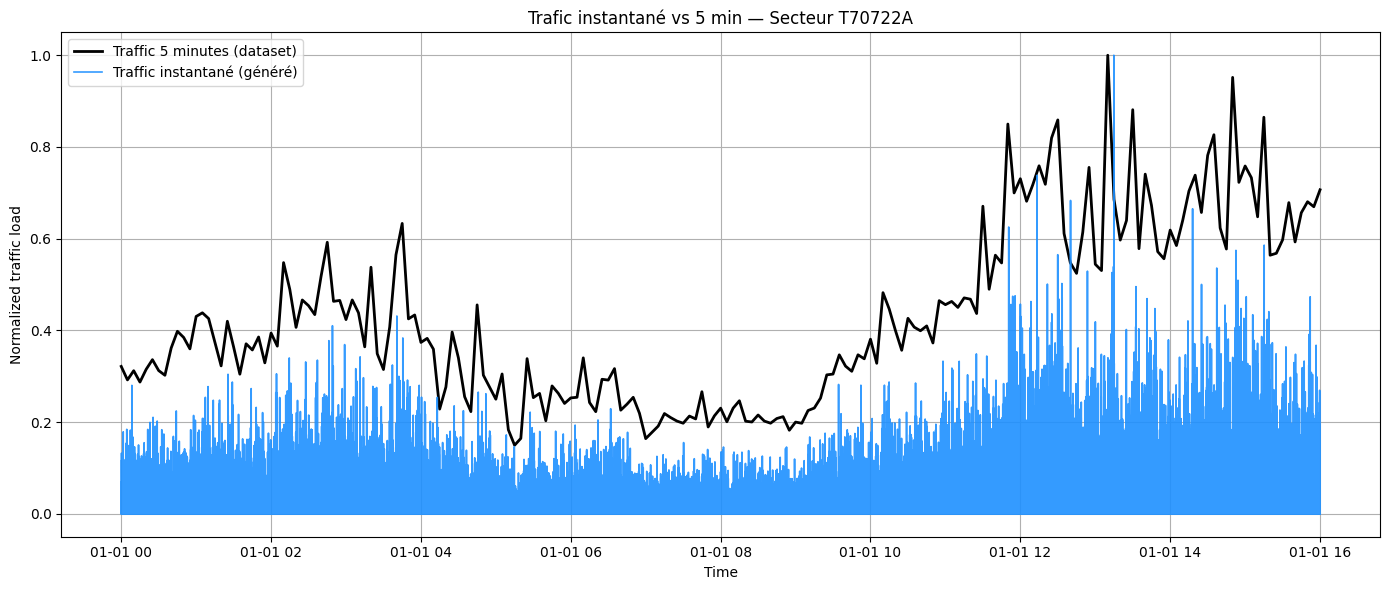

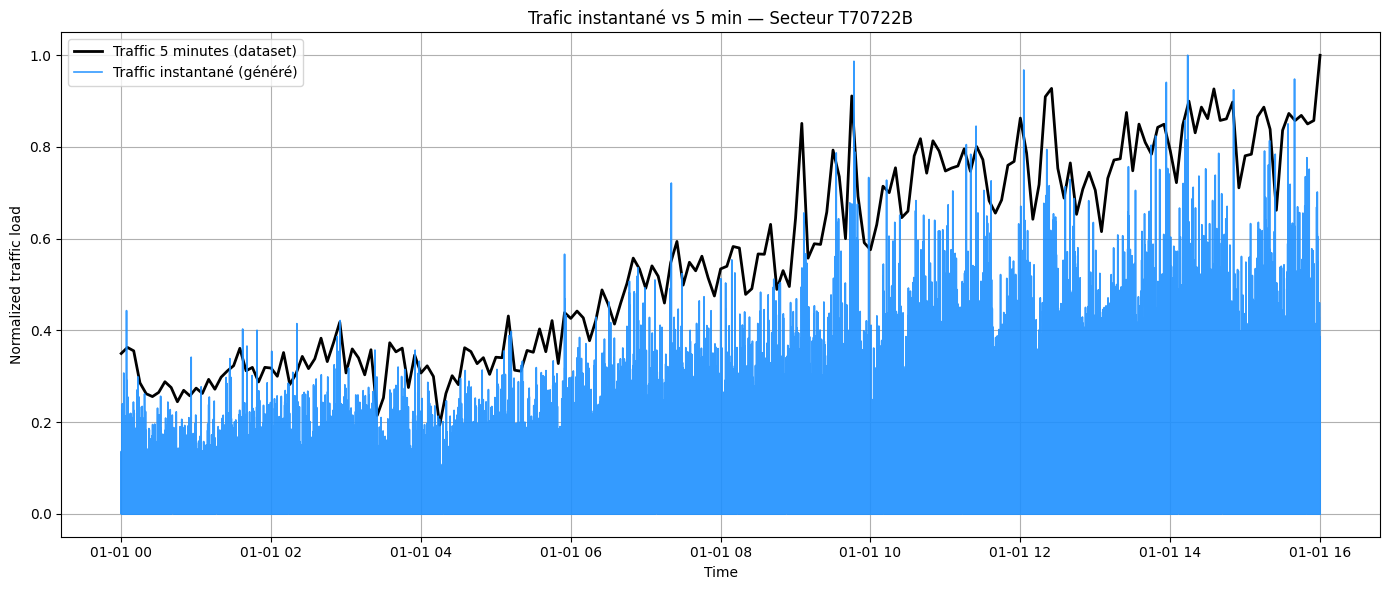

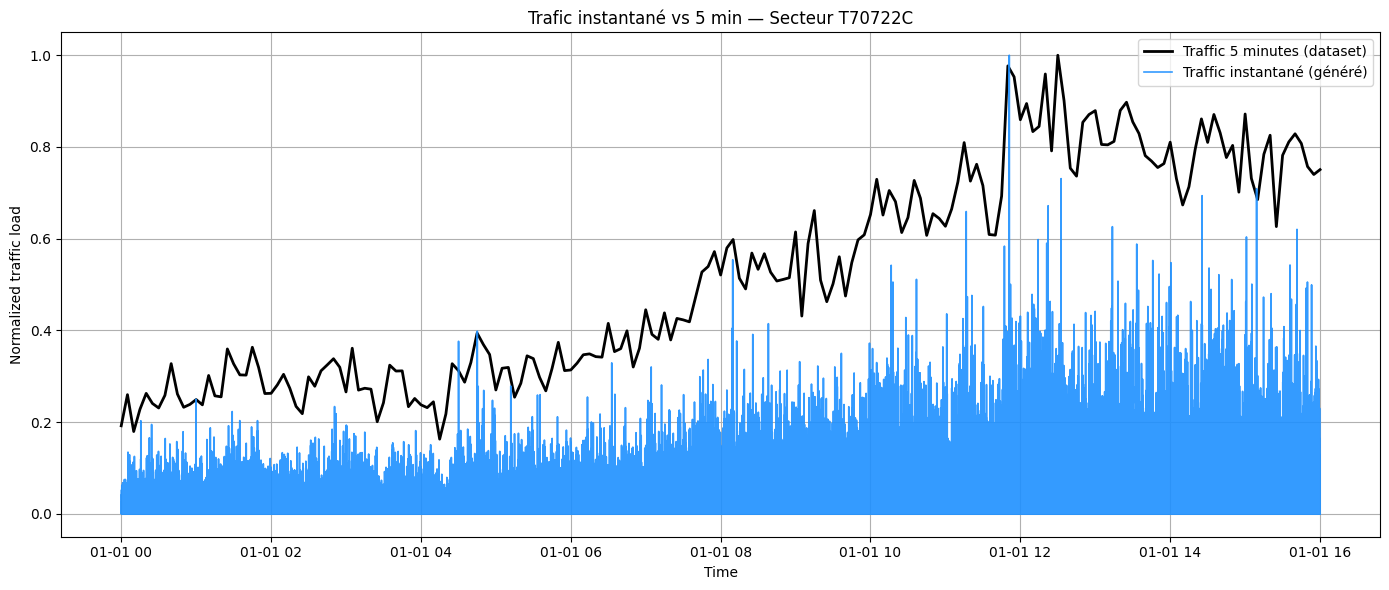

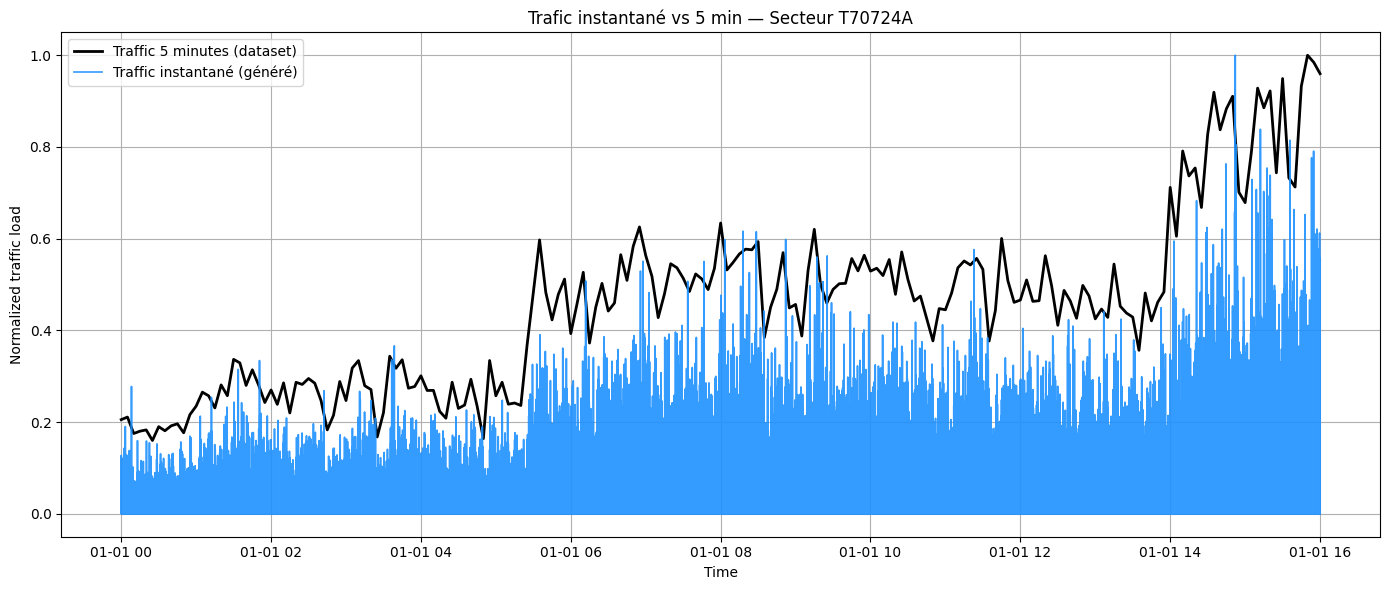

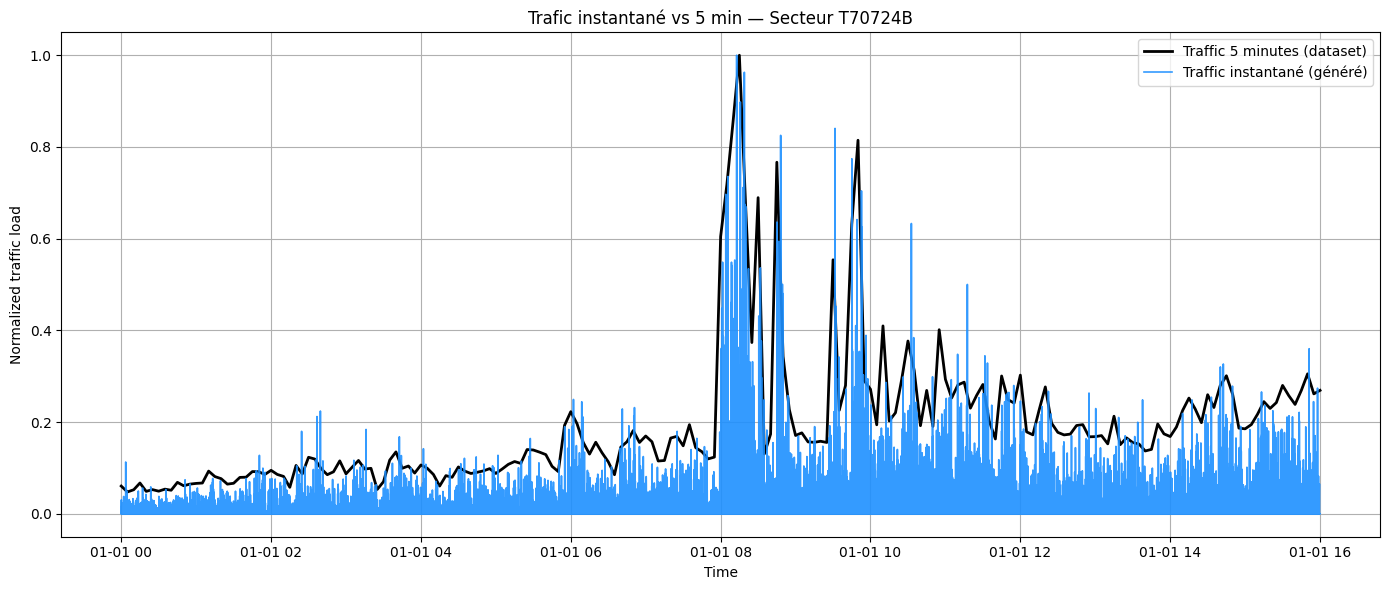

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df5 = pd.read_csv("histo_trafic_avec_dates_5min.csv", sep=None, engine="python")
df5["dates_5min"] = pd.to_datetime(df5["dates_5min"])
df5["trafic_mbps"] = pd.to_numeric(df5["trafic_mbps"], errors="coerce")

dfI = pd.read_csv("instantane.csv")
dfI["timestamp"] = pd.to_datetime(dfI["timestamp"])
dfI["psi_instant"] = pd.to_numeric(dfI["psi_instant"], errors="coerce")

secteurs_to_plot = df5["secteur"].unique()[:10]


for sec in secteurs_to_plot:
    
    df5_sec = df5[df5["secteur"] == sec].sort_values("dates_5min")
    dfI_sec = dfI[dfI["secteur"] == sec].sort_values("timestamp")

    t_min = df5_sec["dates_5min"].min()
    t_max = df5_sec["dates_5min"].max()

    dfI_sec = dfI_sec[(dfI_sec["timestamp"] >= t_min) & (dfI_sec["timestamp"] <= t_max)]


    # Normalisation
    max5 = df5_sec["trafic_mbps"].max()
    maxI = dfI_sec["psi_instant"].max()

    if maxI <= 0:
        print(f"⚠ psi_instant max=0 pour {sec} → pas de fluctuation visible.")
        yI = dfI_sec["psi_instant"]
    else:
        yI = dfI_sec["psi_instant"] / maxI

    y5 = df5_sec["trafic_mbps"] / max5 if max5 > 0 else df5_sec["trafic_mbps"]

    plt.figure(figsize=(14,6))

    plt.plot(df5_sec["dates_5min"], y5,
             label="Traffic 5 minutes (dataset)",
             color="black", linewidth=2)

    plt.plot(dfI_sec["timestamp"], yI,
             label="Traffic instantané (généré)",
             color="dodgerblue", linewidth=1.2, alpha=0.9)

    plt.title(f"Trafic instantané vs 5 min — Secteur {sec}")
    plt.xlabel("Time")
    plt.ylabel("Normalized traffic load")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


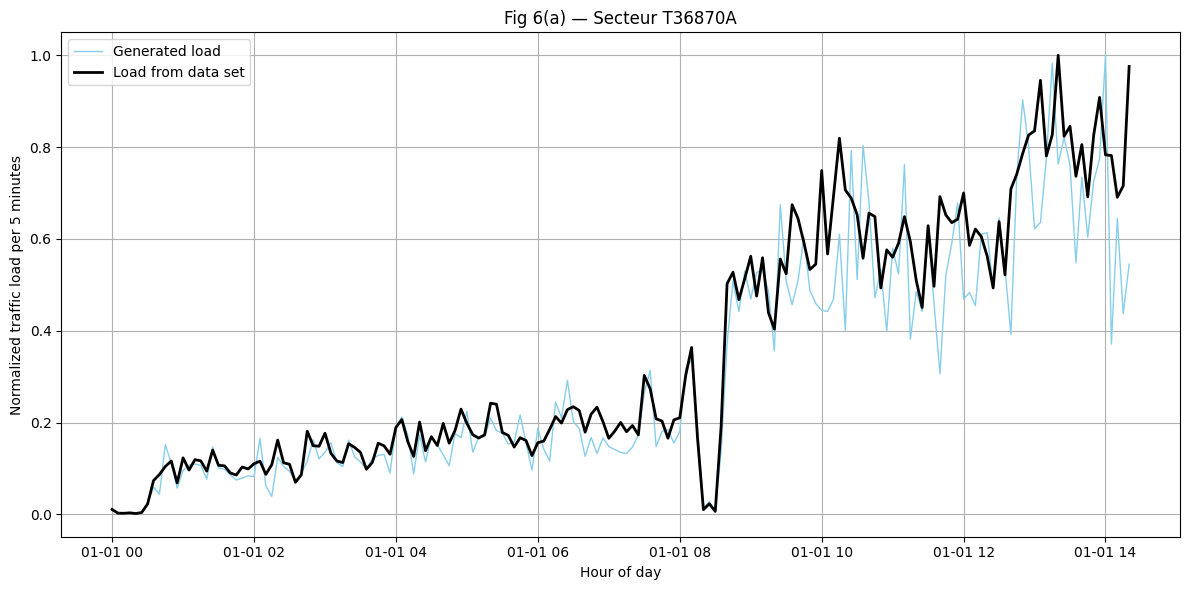

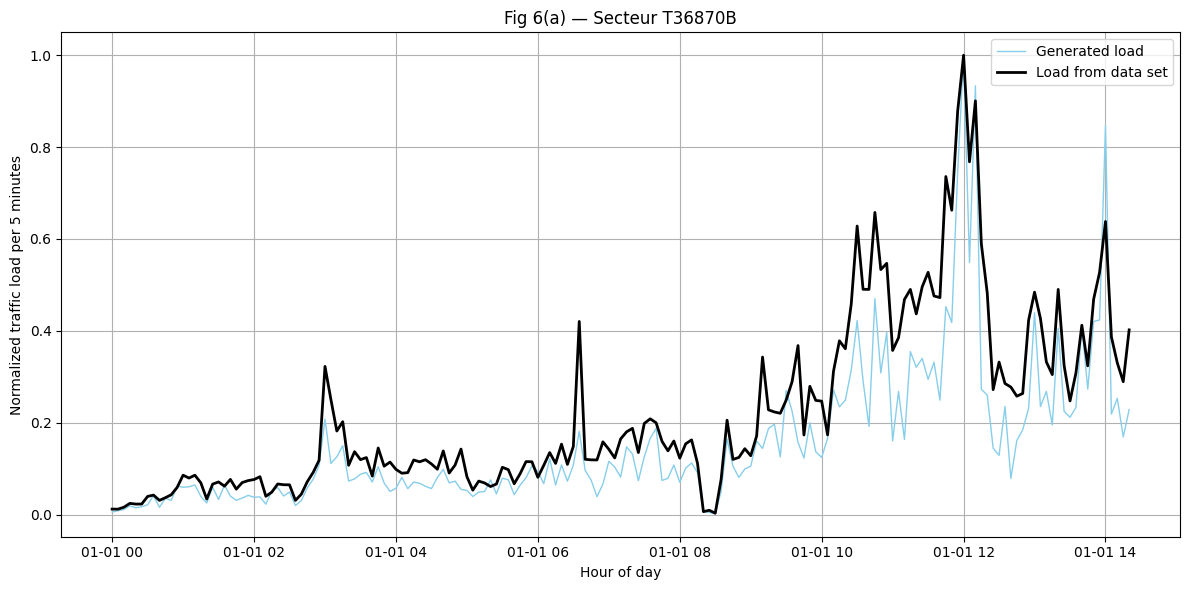

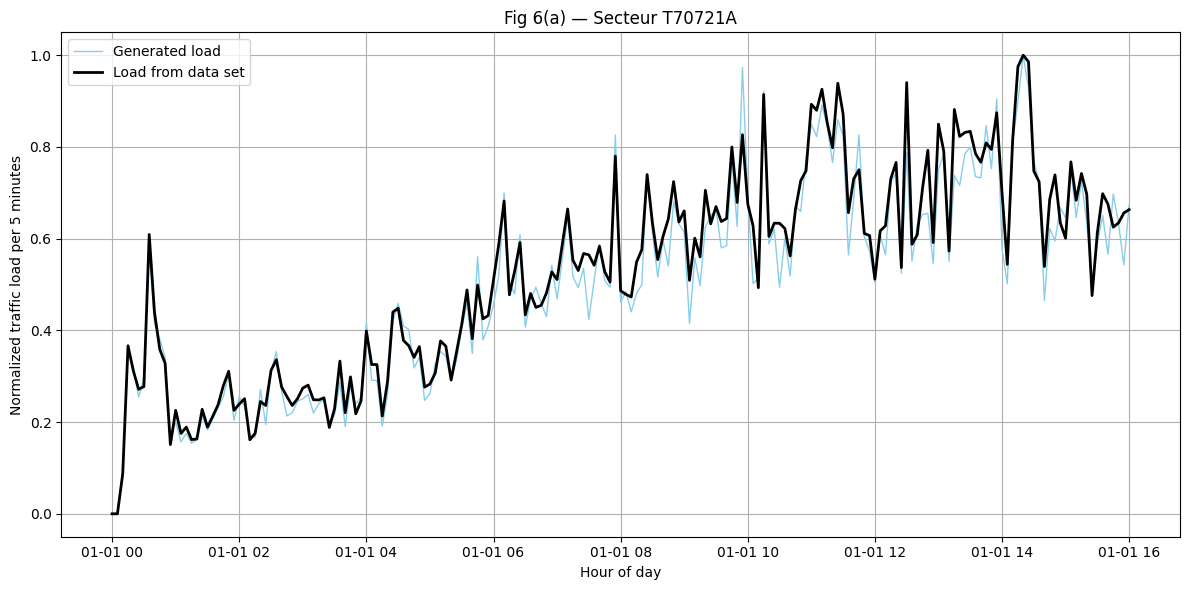

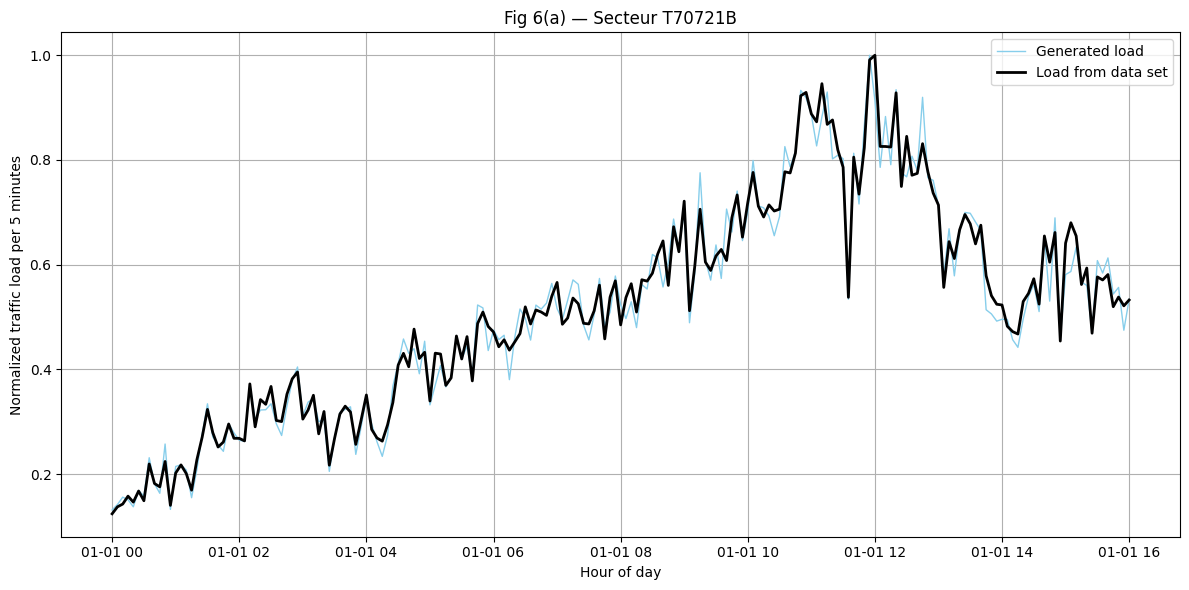

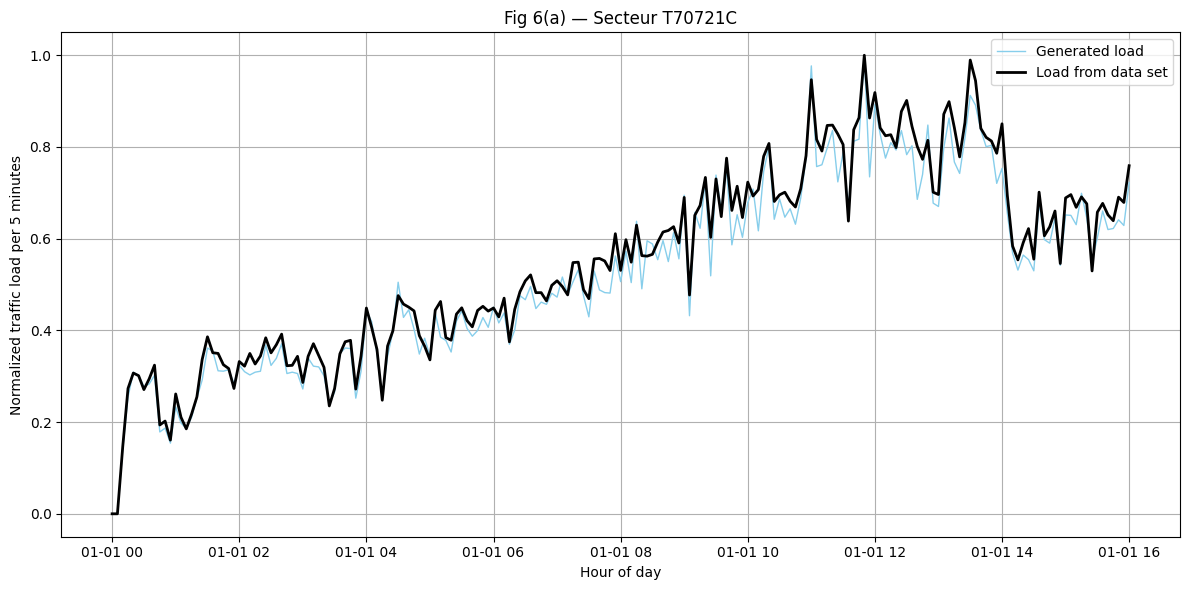

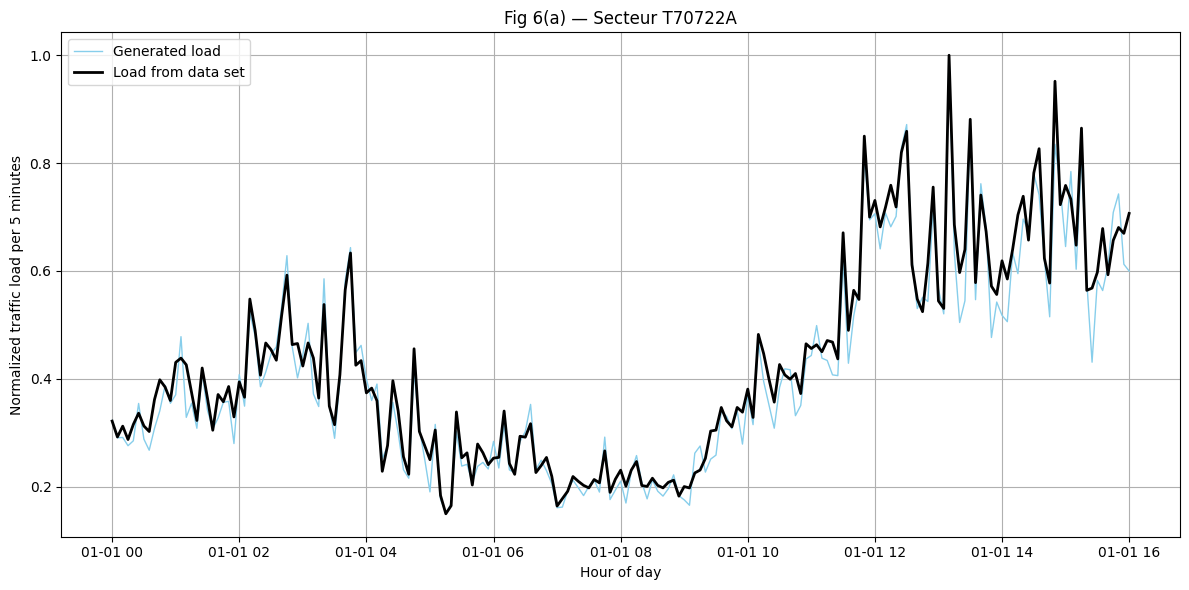

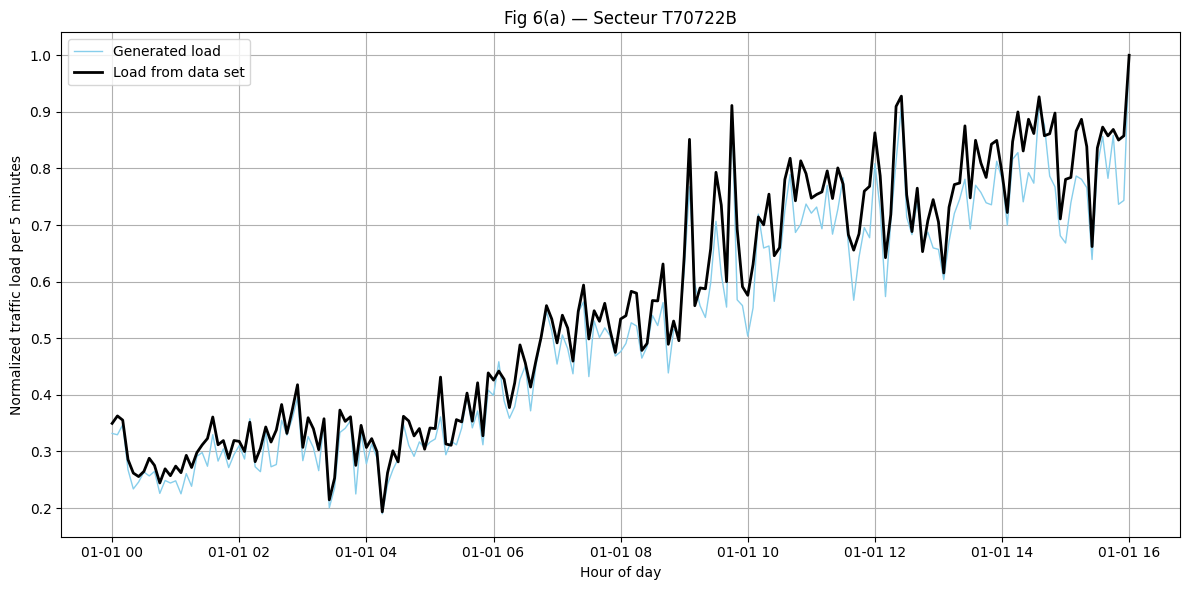

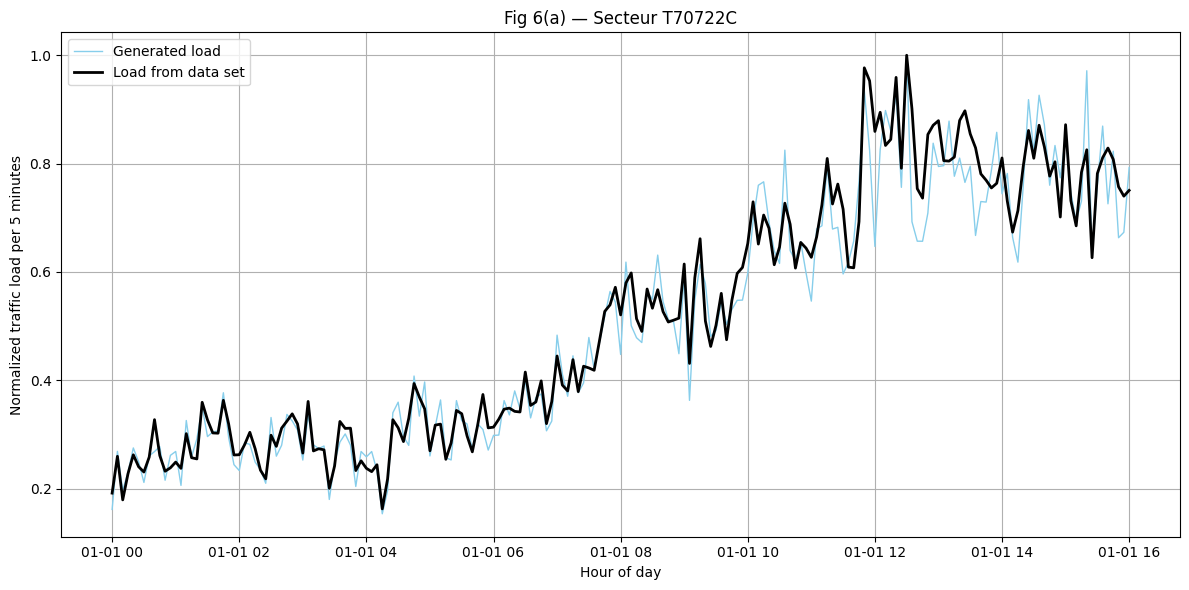

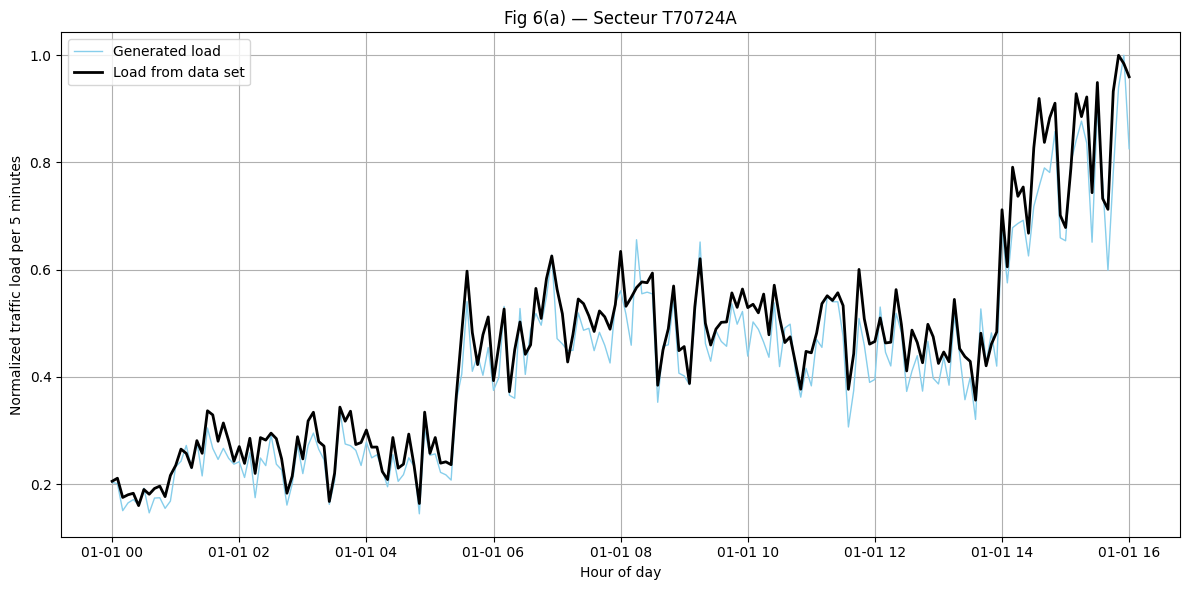

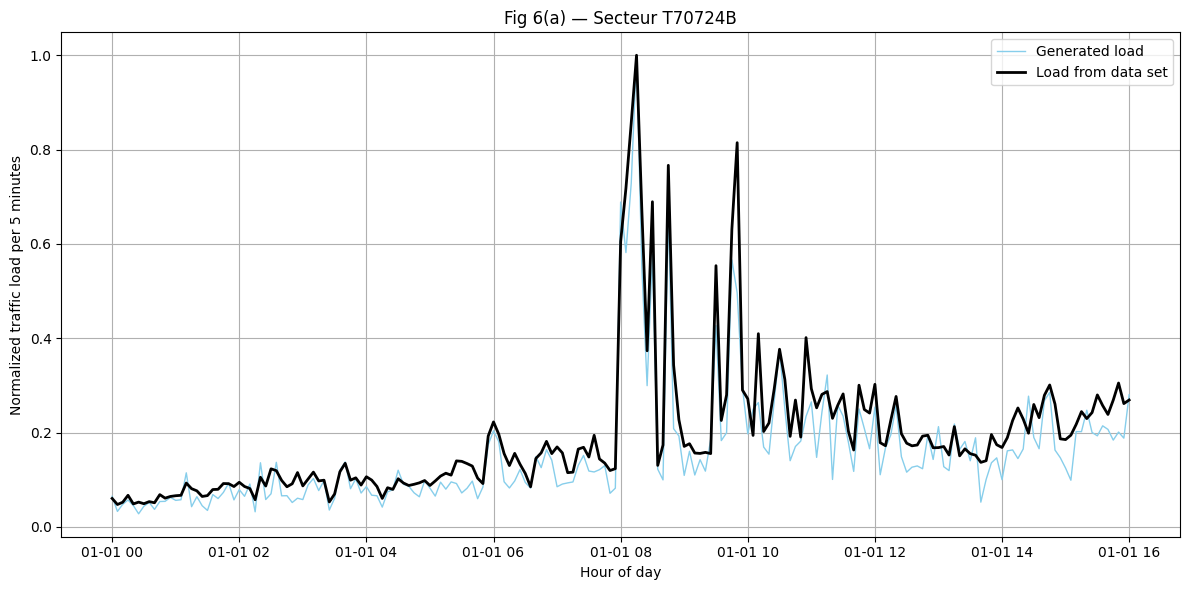

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df5 = pd.read_csv("histo_trafic_avec_dates_5min.csv", sep=";", engine="python")
df5["dates_5min"] = pd.to_datetime(df5["dates_5min"])
df5["trafic_mbps"] = pd.to_numeric(df5["trafic_mbps"], errors="coerce")

dfI = pd.read_csv("instantane.csv")
dfI["timestamp"] = pd.to_datetime(dfI["timestamp"])
dfI["psi_instant"] = pd.to_numeric(dfI["psi_instant"], errors="coerce")

secteurs_to_plot = df5["secteur"].unique()[:10]


for sec in secteurs_to_plot:
    
    df5_sec = df5[df5["secteur"] == sec].sort_values("dates_5min")
    dfI_sec = dfI[dfI["secteur"] == sec].sort_values("timestamp")

    dfI_sec_grouped = (
        dfI_sec
        .set_index("timestamp")
        .resample("5min")
        .sum()
        .reset_index()
    )
    
    merged = pd.merge(
        df5_sec,
        dfI_sec_grouped,
        left_on="dates_5min",
        right_on="timestamp",
        how="inner"
    )

    if merged.empty:
        print(f"⚠ Pas de données instantanées alignées pour {sec}")
        continue

    # Normalisation
    y_real = merged["trafic_mbps"] / merged["trafic_mbps"].max()
    y_gen = merged["psi_instant"] / merged["psi_instant"].max()

    plt.figure(figsize=(12,6))

    plt.plot(merged["dates_5min"], y_gen,
             color="skyblue", linewidth=1,
             label="Generated load")

    plt.plot(merged["dates_5min"], y_real,
             color="black", linewidth=2,
             label="Load from data set")

    plt.title(f"Fig 6(a) — Secteur {sec}")
    plt.xlabel("Hour of day")
    plt.ylabel("Normalized traffic load per 5 minutes")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
